In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import from_unixtime, when, col, lit

In [2]:
import json

In [3]:
#%reset
import pyspark.sql
session = pyspark.sql.SparkSession.builder.appName('Demo').getOrCreate() #\
#    .master('spark://10.64.22.198:7077') \
#    .appName('Demo') #\
#    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
#    .config('spark.driver.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
#    .config('spark.executor.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
#    .config('py-files','helper.py') \
#    .getOrCreate()
    
sqlContext = session

print('SparkSQL sesssion created')

SparkSQL sesssion created


In [4]:
from samples_tthml import *


In [5]:
for s in samples:
    print(BASE,samples[s]['filename'])

../../Files/ttH_Multilep/ mc16_13TeV.aMcAtNloPythia8EvtGen_ttH_r9364_p3832.csv
../../Files/ttH_Multilep/ mc16_13TeV.Sherpa_221_NN30NNLO_ttW_multilegNLO_r9364_p3830.csv


In [6]:
DFList = [] 

label_count=0
for s in samples:
    dsPath = BASE+samples[s]['filename']
    print('Loading {0} sample file'.format(s),'\n',dsPath )   
    tempDF =sqlContext.read\
                .format('csv')\
                .option('header', 'true')\
                .option('inferschema', 'true')\
                .load(dsPath)
    tempDF=tempDF.withColumn('sample', lit(s)) 
    tempDF=tempDF.withColumn('label', lit(label_count)) 
    label_count+=1
    DFList.append(tempDF)

Loading ttH sample file 
 ../../Files/ttH_Multilep/mc16_13TeV.aMcAtNloPythia8EvtGen_ttH_r9364_p3832.csv
Loading ttW sample file 
 ../../Files/ttH_Multilep/mc16_13TeV.Sherpa_221_NN30NNLO_ttW_multilegNLO_r9364_p3830.csv


In [7]:
DFList[0].printSchema()

root
 |-- entry: integer (nullable = true)
 |-- DEtall01: double (nullable = true)
 |-- lep_flavour: integer (nullable = true)
 |-- max_eta: double (nullable = true)
 |-- minDeltaR_LJ_0: double (nullable = true)
 |-- minDeltaR_LJ_1: double (nullable = true)
 |-- Meff: double (nullable = true)
 |-- DRlj00: double (nullable = true)
 |-- min_DRl0b: double (nullable = true)
 |-- min_DRlj_new: double (nullable = true)
 |-- DPhij0MET: double (nullable = true)
 |-- lead_BjetPt: double (nullable = true)
 |-- lead_jet_sumBEff: double (nullable = true)
 |-- sublead_jet_sumBEff: double (nullable = true)
 |-- scale_nom: double (nullable = true)
 |-- pileupEventWeight_090: double (nullable = true)
 |-- MV2c10_70_EventWeight: double (nullable = true)
 |-- JVT_EventWeight: double (nullable = true)
 |-- SherpaNJetWeight: double (nullable = true)
 |-- EventNumber: integer (nullable = true)
 |-- RunYear: integer (nullable = true)
 |-- MET_RefFinal_et: double (nullable = true)
 |-- lep_Pt_0: double (null

In [8]:
total_events = DFList[0].count()
print('There are',total_events,'events')

There are 69902 events


In [9]:
DFList[1].count()

86754

In [10]:
with open("../VarList_30.json") as vardict:
    variablelist = json.load(vardict)[:]
    
variablelist.append("sample")
variablelist.append("label")
variablelist

['DEtall01',
 'lep_flavour',
 'max_eta',
 'minDeltaR_LJ_0',
 'minDeltaR_LJ_1',
 'Meff',
 'DRlj00',
 'min_DRl0b',
 'min_DRlj_new',
 'DPhij0MET',
 'lead_BjetPt',
 'lead_jet_sumBEff',
 'sublead_jet_sumBEff',
 'MET_RefFinal_et',
 'lep_Pt_0',
 'lep_Eta_0',
 'lep_Phi_0',
 'lep_Pt_1',
 'lep_Eta_1',
 'lep_Phi_1',
 'total_charge',
 'Mll01',
 'Ptll01',
 'DRll01',
 'nJets_OR_T',
 'nJets_OR_T_MV2c10_70',
 'HT_lep',
 'HT_jets',
 'lead_jetPt',
 'sublead_jetPt',
 'sample',
 'label']

In [11]:
# Select columns from dataframe
DF = DFList[0].select(variablelist)
DF.printSchema()

root
 |-- DEtall01: double (nullable = true)
 |-- lep_flavour: integer (nullable = true)
 |-- max_eta: double (nullable = true)
 |-- minDeltaR_LJ_0: double (nullable = true)
 |-- minDeltaR_LJ_1: double (nullable = true)
 |-- Meff: double (nullable = true)
 |-- DRlj00: double (nullable = true)
 |-- min_DRl0b: double (nullable = true)
 |-- min_DRlj_new: double (nullable = true)
 |-- DPhij0MET: double (nullable = true)
 |-- lead_BjetPt: double (nullable = true)
 |-- lead_jet_sumBEff: double (nullable = true)
 |-- sublead_jet_sumBEff: double (nullable = true)
 |-- MET_RefFinal_et: double (nullable = true)
 |-- lep_Pt_0: double (nullable = true)
 |-- lep_Eta_0: double (nullable = true)
 |-- lep_Phi_0: double (nullable = true)
 |-- lep_Pt_1: double (nullable = true)
 |-- lep_Eta_1: double (nullable = true)
 |-- lep_Phi_1: double (nullable = true)
 |-- total_charge: integer (nullable = true)
 |-- Mll01: double (nullable = true)
 |-- Ptll01: double (nullable = true)
 |-- DRll01: double (nullab

In [12]:
# Merge all dataset into a single dataframe
for df_ in DFList[1:]:
    DF = DF.union(df_.select(variablelist))

print( 'Partitions: {}'.format(DF.rdd.getNumPartitions()))

Partitions: 8


In [13]:
print('total number of events in the DataFrame  = ', DF.count())
print( 'events in the DataFrame with \"nJets_OR_T > 5\" = ', DF.filter('nJets_OR_T > 5').count())

total number of events in the DataFrame  =  156656
events in the DataFrame with "nJets_OR_T > 5" =  38368


cach dataframe into memory, shared across the Spark cluster nodes

In [14]:
DF = DF.cache()

In [15]:
DF.filter(DF['sample'] == 'ttH')\
  .select('sample','nJets_OR_T','lep_Pt_0','lep_Eta_0','lep_Phi_0','total_charge')\
  .show(5)

+------+----------+---------+-----------+-----------+------------+
|sample|nJets_OR_T| lep_Pt_0|  lep_Eta_0|  lep_Phi_0|total_charge|
+------+----------+---------+-----------+-----------+------------+
|   ttH|         6| 65184.87|  1.3295902|   2.048432|          -2|
|   ttH|         5|40491.316|-0.41755068|-0.65665025|           2|
|   ttH|         4| 80014.03|0.043774348| -1.9746306|          -2|
|   ttH|         5|35063.797|  1.3237612|   3.133612|           2|
|   ttH|         7| 45864.24|  1.9134886| -1.6473318|           2|
+------+----------+---------+-----------+-----------+------------+
only showing top 5 rows



In [16]:
DF.groupBy('label').count().show(2)

+-----+-----+
|label|count|
+-----+-----+
|    1|86754|
|    0|69902|
+-----+-----+



In [17]:
balance_of_classes = DF.filter(DF['label'] == 0).count()/DF.filter(DF['label'] == 1).count()

In [18]:
balance_of_classes

0.8057495907969662

In [19]:
if balance_of_classes > 0.5 or balance_of_classes < 1.5:
    print("rather balanced ds. split to it into train and test dataframes.")
    train, test = DF.randomSplit([0.9,0.1])

rather balanced ds. split to it into train and test dataframes.


In [20]:
def split(df,train_frack=0.9):
    balance_of_classes = df.filter(df['label'] == 0).count()/df.filter(df['label'] == 1).count()
    #balance_of_classes = 0.1
    if not(balance_of_classes > 0.5 and balance_of_classes < 1.5):
        print("Not balanced ds, double check your split")
        return None,None

    print("rather balanced ds. split to it into train and test dataframes.")
    train, test = df.randomSplit([train_frack,1-train_frack])
    return  train, test       



In [21]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 141037
Events for the validation 15619


In [22]:
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col
%matplotlib notebook

def compute_hist(data, feature, target='label', n_bins=100, x_lim=[0,3]):
        
    ## Fix the range
    data = data.where((col(feature)<=x_lim[1]) &
                      (col(feature)>=x_lim[0]))
    
    sgn = data.where(col(target)==1.0) 
    bkg = data.where(col(target)==0.0)

    ## Compute the histograms
    bins_sgn, counts_sgn = sgn.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    bins_bkg, counts_bkg = bkg.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    
    return (bins_sgn, counts_sgn), (bins_bkg, counts_bkg)

In [23]:
sgn = train.where(col('label')==1.0) 

In [24]:
s1=sgn.select('Mll01').rdd.collect()
#.histogram(10)

In [25]:
type(sgn.select('Mll01').rdd)

pyspark.rdd.RDD

In [26]:
divided_list = sgn.select('Mll01').rdd.flatMap(lambda x: x*2)

In [27]:
divided_list.collect()

[319651.44,
 319651.44,
 411149.47,
 411149.47,
 397785.47,
 397785.47,
 544116.75,
 544116.75,
 997788.25,
 997788.25,
 320189.38,
 320189.38,
 309428.9,
 309428.9,
 665792.25,
 665792.25,
 797804.2,
 797804.2,
 360255.53,
 360255.53,
 442838.38,
 442838.38,
 274817.9,
 274817.9,
 376114.1,
 376114.1,
 541297.9,
 541297.9,
 505676.47,
 505676.47,
 471454.75,
 471454.75,
 572183.3,
 572183.3,
 345477.34,
 345477.34,
 298313.8,
 298313.8,
 302125.75,
 302125.75,
 988857.1,
 988857.1,
 410542.03,
 410542.03,
 469894.2,
 469894.2,
 565156.4,
 565156.4,
 341361.84,
 341361.84,
 414419.88,
 414419.88,
 486547.0,
 486547.0,
 251339.97,
 251339.97,
 392636.44,
 392636.44,
 967000.1,
 967000.1,
 476013.94,
 476013.94,
 380549.12,
 380549.12,
 572890.3,
 572890.3,
 288741.25,
 288741.25,
 214743.06,
 214743.06,
 423087.62,
 423087.62,
 217185.69,
 217185.69,
 377379.16,
 377379.16,
 618846.75,
 618846.75,
 534261.1,
 534261.1,
 197087.86,
 197087.86,
 248922.27,
 248922.27,
 334913.9,
 334913.9

In [28]:
divided_list.collect()

[319651.44,
 319651.44,
 411149.47,
 411149.47,
 397785.47,
 397785.47,
 544116.75,
 544116.75,
 997788.25,
 997788.25,
 320189.38,
 320189.38,
 309428.9,
 309428.9,
 665792.25,
 665792.25,
 797804.2,
 797804.2,
 360255.53,
 360255.53,
 442838.38,
 442838.38,
 274817.9,
 274817.9,
 376114.1,
 376114.1,
 541297.9,
 541297.9,
 505676.47,
 505676.47,
 471454.75,
 471454.75,
 572183.3,
 572183.3,
 345477.34,
 345477.34,
 298313.8,
 298313.8,
 302125.75,
 302125.75,
 988857.1,
 988857.1,
 410542.03,
 410542.03,
 469894.2,
 469894.2,
 565156.4,
 565156.4,
 341361.84,
 341361.84,
 414419.88,
 414419.88,
 486547.0,
 486547.0,
 251339.97,
 251339.97,
 392636.44,
 392636.44,
 967000.1,
 967000.1,
 476013.94,
 476013.94,
 380549.12,
 380549.12,
 572890.3,
 572890.3,
 288741.25,
 288741.25,
 214743.06,
 214743.06,
 423087.62,
 423087.62,
 217185.69,
 217185.69,
 377379.16,
 377379.16,
 618846.75,
 618846.75,
 534261.1,
 534261.1,
 197087.86,
 197087.86,
 248922.27,
 248922.27,
 334913.9,
 334913.9

In [29]:
bins_sgn, counts_sgn = sgn.select('Mll01').rdd.flatMap(lambda x: x).histogram(11)

In [30]:
hist_signal, hist_bkg = compute_hist(data=train, feature='Mll01', target='label', n_bins=50, x_lim=[0,300000])


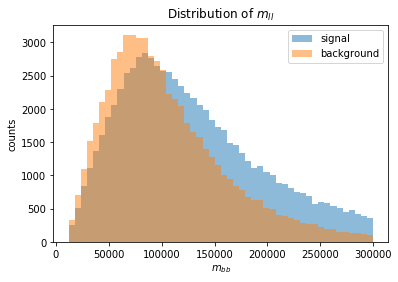

In [31]:

f, ax = plt.subplots()
ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1], alpha=0.5, label='signal')
ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1], alpha=0.5, label='background')
ax.set_xlabel('$m_{bb}$')
ax.set_ylabel('counts')
ax.set_title("Distribution of $m_{ll}$")
ax.legend()
plt.show()

In [32]:
feature_to_train = train.columns
feature_to_train.remove('label')
feature_to_train.remove('sample')
feature_to_train

['DEtall01',
 'lep_flavour',
 'max_eta',
 'minDeltaR_LJ_0',
 'minDeltaR_LJ_1',
 'Meff',
 'DRlj00',
 'min_DRl0b',
 'min_DRlj_new',
 'DPhij0MET',
 'lead_BjetPt',
 'lead_jet_sumBEff',
 'sublead_jet_sumBEff',
 'MET_RefFinal_et',
 'lep_Pt_0',
 'lep_Eta_0',
 'lep_Phi_0',
 'lep_Pt_1',
 'lep_Eta_1',
 'lep_Phi_1',
 'total_charge',
 'Mll01',
 'Ptll01',
 'DRll01',
 'nJets_OR_T',
 'nJets_OR_T_MV2c10_70',
 'HT_lep',
 'HT_jets',
 'lead_jetPt',
 'sublead_jetPt']

In [33]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_to_train, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [34]:
train.select('features').take(1)

[Row(features=DenseVector([-4.2868, 3.0, 2.2209, 0.8435, 2.3613, 1137995.9, 4.6563, 1.5445, 1.3512, 0.7567, 143112.08, 4.0, 3.0, 10845.774, 55696.42, -2.0659, -1.7958, 22471.736, 2.2209, -1.1384, 2.0, 298443.6, 74756.33, 4.3369, 7.0, 2.0, 78168.16, 486970.53, 143112.08, 81340.016]))]

In [35]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(train.select('features'), 'features')
matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

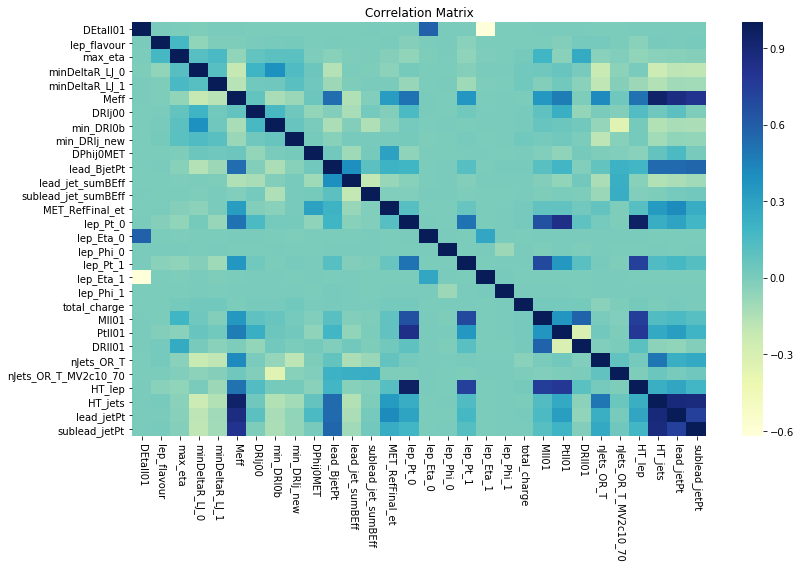

In [36]:
import seaborn as sns

matrix_np = matrix_np.reshape(len(feature_to_train),len(feature_to_train))

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(matrix_np, cmap="YlGnBu")
ax.xaxis.set_ticklabels(feature_to_train, rotation=270)
ax.yaxis.set_ticklabels(feature_to_train, rotation=0)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [37]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10)

In [38]:
%%time
gbt_model = gbt.fit(train)

CPU times: user 26.8 ms, sys: 13.7 ms, total: 40.5 ms
Wall time: 3min 40s


In [39]:
pred_gbt = gbt_model.transform(test)

In [42]:
pred_gbt

DataFrame[DEtall01: double, lep_flavour: int, max_eta: double, minDeltaR_LJ_0: double, minDeltaR_LJ_1: double, Meff: double, DRlj00: double, min_DRl0b: double, min_DRlj_new: double, DPhij0MET: double, lead_BjetPt: double, lead_jet_sumBEff: double, sublead_jet_sumBEff: double, MET_RefFinal_et: double, lep_Pt_0: double, lep_Eta_0: double, lep_Phi_0: double, lep_Pt_1: double, lep_Eta_1: double, lep_Phi_1: double, total_charge: int, Mll01: double, Ptll01: double, DRll01: double, nJets_OR_T: int, nJets_OR_T_MV2c10_70: int, HT_lep: double, HT_jets: double, lead_jetPt: double, sublead_jetPt: double, sample: string, label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [40]:
pred_pd_gbt = pred_gbt.select(['label', 'prediction', 'probability']).toPandas()

In [43]:
pred_pd_gbt.head()

,label,prediction,probability
0,0,1.0,"[0.04008665222485402, 0.959913347775146]"
1,0,1.0,"[0.056507600148231064, 0.9434923998517689]"
2,0,1.0,"[0.16460704318140373, 0.8353929568185963]"
3,0,1.0,"[0.0892150431479271, 0.910784956852073]"
4,0,0.0,"[0.5217474955847694, 0.4782525044152306]"


In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [45]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

In [48]:
accuracy = evaluator.evaluate(pred_gbt)
print(accuracy)

0.6886484410013445


In [47]:
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.311352 


In [49]:
import numpy as np

In [50]:
pred_pd_gbt['probability'] = pred_pd_gbt['probability'].map(lambda x: list(x))
pred_pd_gbt['encoded_label'] = pred_pd_gbt['label'].map(lambda x: np.eye(2)[int(x)])

y_pred_gbt = np.array(pred_pd_gbt['probability'].tolist())
y_true_gbt = np.array(pred_pd_gbt['encoded_label'].tolist())

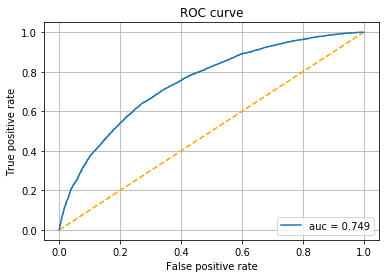

In [51]:
from sklearn.metrics import auc, roc_curve
fpr_gbt, tpr_gbt, threshold_gbt = roc_curve(y_score=y_pred_gbt[:,0], y_true=y_true_gbt[:,0])
auc_gbt = auc(fpr_gbt, tpr_gbt)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_gbt, tpr_gbt, label='auc = {:.3f}'.format(auc_gbt))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('BDT ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [52]:
print(auc_gbt)

0.7485325908632654


In [53]:
gbt_model.write().overwrite().save(path='models/bdt_spark_tth')

In [ ]:
from pyspark.ml.classification import GBTClassificationModel

In [ ]:
loaded_bdt=GBTClassificationModel.load('models/bdt_spark_tth')

In [ ]:
pred_full = loaded_bdt.transform(test)

In [ ]:
hist_signal_pred, hist_bkg_pred = compute_hist(data=pred_full, feature='Mll01', target='label', n_bins=50, x_lim=[0,300000])


In [ ]:
#hist_signal[1][:-1]

In [ ]:

f, ax = plt.subplots()
ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1],
        alpha=0.5, label='signal', density=True)
ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1],
        alpha=0.5, label='background', density=True)

ax.hist(hist_signal_pred[0][:-1], bins=hist_signal_pred[0], weights=hist_signal_pred[1],
        label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2, density=True)
ax.hist(hist_bkg_pred[0][:-1], bins=hist_bkg_pred[0], weights=hist_bkg_pred[1],
        label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2, density=True)

ax.set_xlabel('$m_{ll}$')
ax.set_ylabel('counts')
ax.legend()
ax.set_title("Distribution of $m_{ll}$")
plt.savefig("Plots/SparkOut/Mll01_pred.png", transparent=True)
plt.show()